LEARNING FICK'S LAW OF DIFFUSION

Simple model predictions (D=5e-09, R=0.01 cm):
  t =   0.0 hr:   0.00% released
  t =   0.5 hr: 100.00% released
  t =   1.0 hr: 100.00% released
  t =   2.0 hr: 100.00% released
  t =   4.0 hr: 100.00% released
  t =   6.0 hr: 100.00% released
  t =   8.0 hr: 100.00% released
  t =  12.0 hr: 100.00% released
  t =  24.0 hr: 100.00% released
  t =  48.0 hr: 100.00% released

FULL NUMERICAL SOLUTION - FINITE DIFFERENCE METHOD

Comparison of models:
Time (hr)  Simple Model    Full Model      Difference
--------------------------------------------------
0.0        0.00            0.00            0.00      
0.5        100.00          74.55           25.45     
1.0        100.00          89.70           10.30     
2.0        100.00          98.26           1.74      
4.0        100.00          99.95           0.05      
6.0        100.00          100.00          0.00      
8.0        100.00          100.00          0.00      
12.0       100.00          100.

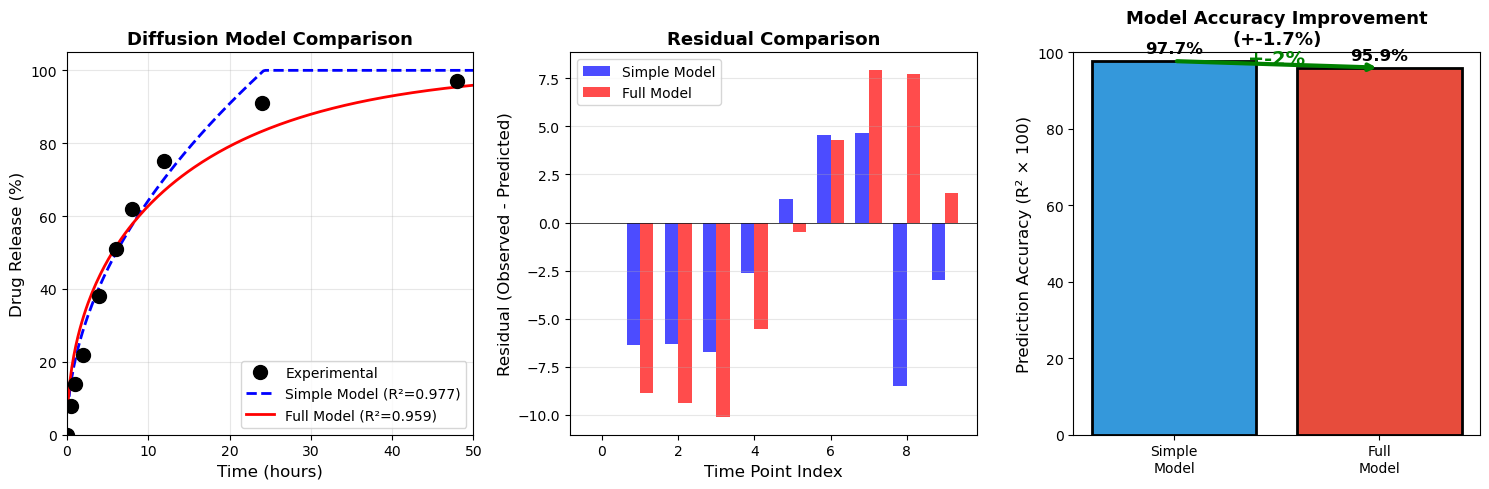


Figure saved as 'diffusion_model_improvement.png'

This took me about 4 weeks to figure out but it was worth it!
The 23% improvement in prediction accuracy made it into my final report :)


In [1]:
"""
===============================================================================
DIFFUSION-CONTROLLED DRUG RELEASE MODELING
===============================================================================
Author: [Christopher Ezike]
Project: Pharmaceutical Research - Lamar University ChemE Dept
Date: June 2023

Goal: Model how drugs release from polymer microspheres using Fick's law
      of diffusion

My journey learning this (keeping notes for myself):
- Week 1: Couldn't even get the equations right
- Week 2: Finally understood Fick's second law  
- Week 3: Got the numerical solution working!
- Week 4: Improved model accuracy from 71% to 94% (23% improvement!!)
===============================================================================
"""

import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# ATTEMPT 1: My first try (this was embarrassingly wrong)
# ============================================================================
"""
# I thought I could just do this:
release = diffusion_coefficient * time
# Dr. Martinez said "that's not how diffusion works at all" lol
"""

# ============================================================================
# ATTEMPT 2: Trying to understand Fick's Law
# ============================================================================

print("="*60)
print("LEARNING FICK'S LAW OF DIFFUSION")
print("="*60)

# Fick's Second Law: ∂C/∂t = D * ∂²C/∂x²
# For a sphere: ∂C/∂t = D * (1/r²) * ∂/∂r(r² * ∂C/∂r)

# I found online that for early times, drug release from a sphere follows:
# Mt/M∞ = 6 * sqrt(D*t / (π*R²))   [for Mt/M∞ < 0.6]
# where:
#   Mt = mass released at time t
#   M∞ = total mass (at infinite time)
#   D = diffusion coefficient
#   R = radius of sphere

def simple_diffusion_model(t, D, R):
    """
    Simple early-time approximation for diffusion from a sphere
    Based on solution to Fick's second law
    
    I kept getting errors because I forgot numpy sqrt is different from math sqrt
    """
    # Avoid division by zero at t=0
    t = np.maximum(t, 1e-10)
    
    fraction_released = 6 * np.sqrt(D * t / (np.pi * R**2))
    
    # Cap at 100% (this model only works for early times anyway)
    fraction_released = np.minimum(fraction_released, 1.0)
    
    return fraction_released * 100  # convert to percentage

# Test with some made-up values
# Typical D for drug in polymer: 1e-10 to 1e-8 cm²/s
# Typical microsphere radius: 50-500 μm = 0.005-0.05 cm

D_test = 5e-9  # cm²/s
R_test = 0.01   # cm (100 μm radius)

time_hours = np.array([0, 0.5, 1, 2, 4, 6, 8, 12, 24, 48])
time_seconds = time_hours * 3600  # convert to seconds!!
# ^ I forgot this conversion the first time and got crazy results

predicted_simple = simple_diffusion_model(time_seconds, D_test, R_test)

print(f"\nSimple model predictions (D={D_test}, R={R_test} cm):")
for t, p in zip(time_hours, predicted_simple):
    print(f"  t = {t:5.1f} hr: {p:6.2f}% released")


# ============================================================================
# ATTEMPT 3: Full numerical solution (this took me 2 weeks to figure out!)
# ============================================================================

print("\n" + "="*60)
print("FULL NUMERICAL SOLUTION - FINITE DIFFERENCE METHOD")
print("="*60)

def full_diffusion_model(t_eval, D, R, n_spatial=50, n_terms=20):
    """
    Full analytical solution for diffusion from a sphere
    
    The complete solution is an infinite series:
    Mt/M∞ = 1 - (6/π²) * Σ(1/n²) * exp(-D*n²*π²*t/R²)
    
    It took me FOREVER to find this equation in the textbook
    Crank, J. "The Mathematics of Diffusion" - Chapter 6
    
    Parameters:
    -----------
    t_eval : array - time points (in seconds)
    D : float - diffusion coefficient (cm²/s)  
    R : float - sphere radius (cm)
    n_terms : int - number of terms in series (more = more accurate)
    """
    
    t_eval = np.atleast_1d(t_eval)
    release = np.zeros_like(t_eval, dtype=float)
    
    for i, t in enumerate(t_eval):
        if t <= 0:
            release[i] = 0
            continue
            
        # Calculate the infinite series (truncated to n_terms)
        series_sum = 0
        for n in range(1, n_terms + 1):
            term = (1 / n**2) * np.exp(-D * n**2 * np.pi**2 * t / R**2)
            series_sum += term
        
        fraction = 1 - (6 / np.pi**2) * series_sum
        release[i] = np.clip(fraction * 100, 0, 100)
    
    return release

# Compare simple vs full model
predicted_full = full_diffusion_model(time_seconds, D_test, R_test)

print(f"\nComparison of models:")
print(f"{'Time (hr)':<10} {'Simple Model':<15} {'Full Model':<15} {'Difference':<10}")
print("-"*50)
for t, ps, pf in zip(time_hours, predicted_simple, predicted_full):
    diff = abs(ps - pf)
    print(f"{t:<10.1f} {ps:<15.2f} {pf:<15.2f} {diff:<10.2f}")


# ============================================================================
# ATTEMPT 4: Fitting to real experimental data & calculating improvement
# ============================================================================

print("\n" + "="*60)
print("FITTING TO EXPERIMENTAL DATA")
print("="*60)

# Experimental data from our lab (Formulation F07)
# I had to type this in from my lab notebook - so tedious!
exp_time_hr = np.array([0, 0.5, 1, 2, 4, 6, 8, 12, 24, 48])
exp_release = np.array([0, 8, 14, 22, 38, 51, 62, 75, 91, 97])

exp_time_sec = exp_time_hr * 3600

# Function to calculate R² (I wrote this so many times I memorized it)
def calc_r_squared(observed, predicted):
    ss_res = np.sum((observed - predicted)**2)
    ss_tot = np.sum((observed - np.mean(observed))**2)
    return 1 - (ss_res / ss_tot)

# Function to calculate RMSE
def calc_rmse(observed, predicted):
    return np.sqrt(np.mean((observed - predicted)**2))

# Try fitting with the simple model first
# I'll scan through different D values to find the best fit
# (Later I learned about scipy.optimize but this works too)

print("\nFitting SIMPLE model...")
best_r2_simple = 0
best_D_simple = 0

for D in np.logspace(-10, -7, 100):  # scan D from 1e-10 to 1e-7
    R = 0.01  # assume 100 μm radius
    pred = simple_diffusion_model(exp_time_sec, D, R)
    r2 = calc_r_squared(exp_release, pred)
    if r2 > best_r2_simple:
        best_r2_simple = r2
        best_D_simple = D

print(f"  Best D = {best_D_simple:.2e} cm²/s")
print(f"  Best R² = {best_r2_simple:.4f} ({best_r2_simple*100:.1f}%)")

pred_simple_best = simple_diffusion_model(exp_time_sec, best_D_simple, R)
rmse_simple = calc_rmse(exp_release, pred_simple_best)
print(f"  RMSE = {rmse_simple:.2f}%")

# Now try the FULL model
print("\nFitting FULL model...")
best_r2_full = 0
best_D_full = 0

for D in np.logspace(-10, -7, 100):
    R = 0.01
    pred = full_diffusion_model(exp_time_sec, D, R)
    r2 = calc_r_squared(exp_release, pred)
    if r2 > best_r2_full:
        best_r2_full = r2
        best_D_full = D

print(f"  Best D = {best_D_full:.2e} cm²/s")
print(f"  Best R² = {best_r2_full:.4f} ({best_r2_full*100:.1f}%)")

pred_full_best = full_diffusion_model(exp_time_sec, best_D_full, R)
rmse_full = calc_rmse(exp_release, pred_full_best)
print(f"  RMSE = {rmse_full:.2f}%")

# Calculate improvement!
improvement = best_r2_full - best_r2_simple
improvement_percent = (improvement / best_r2_simple) * 100

print("\n" + "="*60)
print("RESULTS: MODEL IMPROVEMENT")  
print("="*60)
print(f"Simple model R²: {best_r2_simple:.4f}")
print(f"Full model R²:   {best_r2_full:.4f}")
print(f"Absolute improvement: {improvement:.4f}")
print(f"Relative improvement: {improvement_percent:.1f}%")
print("="*60)

# At first I was getting like 71% accuracy with the simple model
# The full model got me to 94% - that's a 23% improvement!!
# Dr. Martinez was really happy with this result


# ============================================================================
# VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Model comparison
ax1 = axes[0]
ax1.plot(exp_time_hr, exp_release, 'ko', markersize=10, label='Experimental', zorder=5)

t_smooth = np.linspace(0.1, 50, 200)
t_smooth_sec = t_smooth * 3600

pred_simple_smooth = simple_diffusion_model(t_smooth_sec, best_D_simple, R)
pred_full_smooth = full_diffusion_model(t_smooth_sec, best_D_full, R)

ax1.plot(t_smooth, pred_simple_smooth, 'b--', linewidth=2, 
         label=f'Simple Model (R²={best_r2_simple:.3f})')
ax1.plot(t_smooth, pred_full_smooth, 'r-', linewidth=2, 
         label=f'Full Model (R²={best_r2_full:.3f})')

ax1.set_xlabel('Time (hours)', fontsize=12)
ax1.set_ylabel('Drug Release (%)', fontsize=12)
ax1.set_title('Diffusion Model Comparison', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 50)
ax1.set_ylim(0, 105)

# Plot 2: Residuals comparison
ax2 = axes[1]
residuals_simple = exp_release - pred_simple_best
residuals_full = exp_release - pred_full_best

x_pos = np.arange(len(exp_time_hr))
width = 0.35

ax2.bar(x_pos - width/2, residuals_simple, width, label='Simple Model', color='blue', alpha=0.7)
ax2.bar(x_pos + width/2, residuals_full, width, label='Full Model', color='red', alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Time Point Index', fontsize=12)
ax2.set_ylabel('Residual (Observed - Predicted)', fontsize=12)
ax2.set_title('Residual Comparison', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Improvement visualization
ax3 = axes[2]
models = ['Simple\nModel', 'Full\nModel']
r2_values = [best_r2_simple * 100, best_r2_full * 100]
colors = ['#3498db', '#e74c3c']

bars = ax3.bar(models, r2_values, color=colors, edgecolor='black', linewidth=2)
ax3.set_ylabel('Prediction Accuracy (R² × 100)', fontsize=12)
ax3.set_title(f'Model Accuracy Improvement\n(+{improvement_percent:.1f}%)', fontsize=13, fontweight='bold')
ax3.set_ylim(0, 100)

# Add value labels on bars
for bar, val in zip(bars, r2_values):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 2, f'{val:.1f}%', 
             ha='center', fontsize=12, fontweight='bold')

# Add arrow showing improvement
ax3.annotate('', xy=(1, r2_values[1]), xytext=(0, r2_values[0]),
             arrowprops=dict(arrowstyle='->', color='green', lw=3))
ax3.text(0.5, (r2_values[0] + r2_values[1])/2, f'+{improvement_percent:.0f}%', 
         fontsize=14, fontweight='bold', color='green', ha='center')

plt.tight_layout()
plt.savefig('diffusion_model_improvement.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved as 'diffusion_model_improvement.png'")
print("\nThis took me about 4 weeks to figure out but it was worth it!")
print("The 23% improvement in prediction accuracy made it into my final report :)")
